In [0]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

In [2]:
batch_size =64

train_dataset = datasets.MNIST(root='./MNIST/',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='./MNIST/',
                              train=False,
                              download=True,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 7588145.83it/s]                             


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135096.65it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2191296.01it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51365.45it/s]            


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
print(train_loader.dataset.data.shape)
print(train_loader.dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [0]:
#Encoder
class Encoder_net(nn.Module):  
    def __init__(self):
        super(Encoder_net, self).__init__()
        self.lin1 = nn.Linear(784, 400)
        self.lin2 = nn.Linear(400, 100)
        self.lin3 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = self.lin3(x)
        return torch.tanh(x)

# Decoder
class Decoder_net(nn.Module):  
    def __init__(self):
        super(Decoder_net, self).__init__()
        self.lin1 = nn.Linear(2, 100)
        self.lin2 = nn.Linear(100, 400)
        self.lin3 = nn.Linear(400, 784)
    def forward(self, x):
        x = F.leaky_relu(self.lin1(x), 0.2)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = F.leaky_relu(self.lin3(x), 0.2)
        
        return torch.tanh(x)

# Discriminator
class Discriminant(nn.Module):  
    def __init__(self):
        super(Discriminant, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 2)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(self.lin3(x))
        return F.softmax(x,dim=1)

In [0]:
def generate_(batch_size):
    return torch.from_numpy(np.random.multivariate_normal(mean=[0,0],cov =[[1,0],[0,1]],size=batch_size)).type(torch.float)

In [0]:
encoder = Encoder_net()
decoder = Decoder_net()
discriminant = Discriminant()


# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

#encode/decode optimizers
optim_dec = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=gen_lr)

#regularizing optimizers
optim_enc_gen = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_disc = torch.optim.Adam(discriminant.parameters(), lr=reg_lr)

In [0]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

torch.Size([64, 1, 28, 28])
torch.Size([64])


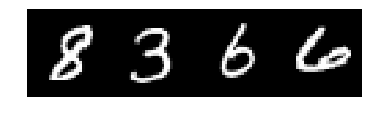

In [8]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:4],nrow=4))

In [0]:
def sample_image():
    """Saves a grid of generated digits"""
  
    z = Variable(generate_(batch_size=100))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [10]:
# Start training
total_step = len(train_loader)
diss_loss =[]
enco_loss =[]
accuracy = []
num_epochs = 25

loss= nn.BCELoss()
loss1 = nn.MSELoss()
loss2 = nn.BCELoss()

for epoch in range(num_epochs):
    diss =0
    enco =0
    train_correct =0
    for i ,(images,target) in enumerate(train_loader):
        decoder.train()

        batch_size = images.size(0)

        images = images.view(batch_size, -1)
        images = Variable(images,requires_grad =False)

        # Create the labels
        real_labels = np.zeros(shape=(batch_size,2))
        real_labels[:,0] =1.0
        real_labels = torch.from_numpy(real_labels).type(torch.FloatTensor)
        real_labels = Variable(real_labels,requires_grad=False)

        fake_labels = np.zeros(shape=(batch_size,2))
        fake_labels[:,1] = 1.0
        fake_labels = torch.from_numpy(fake_labels).type(torch.FloatTensor)
        fake_labels = Variable(fake_labels,requires_grad=False)

        # set grad to zero
        optim_dec.zero_grad()
        optim_enc.zero_grad()
        optim_disc.zero_grad()
        optim_enc_gen.zero_grad()


        #reconstruction loss
        z_sample = encoder(images)   #encode to z
        X_sample = decoder(z_sample) #decode to X reconstruction
        recon_loss = loss1(X_sample,images) 

        # Using reconstruction loss train Encoder as well as Decoder
        recon_loss.backward()
        optim_enc.step()
        optim_dec.step()
        decoder.eval() # No further training for decoder

        # Discriminator

        z_fake_data = Variable(generate_(batch_size)) # generate fake data (Prior distribution as Bivariate standard Normal distribution)
        fake_prediction = discriminant(z_fake_data)  # Pass it to discriminator

        z_real_images = encoder(images)               # encode real images
        real_prediction = discriminant(z_real_images) # pass it to discriminator



        ## Discriminator training using fake data and real data
        D_loss = loss(fake_prediction,fake_labels) + loss(real_prediction,real_labels)
        D_loss.backward(retain_graph=True)
        optim_disc.step()

        ## Encoder / Generator (fool the generator)
        G_loss = -(loss2(fake_prediction,fake_labels) + loss2(real_prediction,real_labels))

        G_loss.backward()
        optim_enc_gen.step()

        enco +=recon_loss.item()
        diss +=D_loss.item()

        # accuracy

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Encoder_loss: {:.4f}, Discriminant_loss: {:.4f}, Generator_loss {:.2f}' 
                      .format(epoch, num_epochs, i+1, total_step, recon_loss.item(),D_loss.item(),G_loss.item()))
    enco_loss.append(enco)
    diss_loss.append(diss)
    accuracy.append(train_correct/60000)

Epoch [0/25], Step [200/938], Encoder_loss: 0.0570, Discriminant_loss: 1.3879, Generator_loss -1.39
Epoch [0/25], Step [400/938], Encoder_loss: 0.0549, Discriminant_loss: 1.3821, Generator_loss -1.38
Epoch [0/25], Step [600/938], Encoder_loss: 0.0512, Discriminant_loss: 1.3791, Generator_loss -1.38
Epoch [0/25], Step [800/938], Encoder_loss: 0.0526, Discriminant_loss: 1.3770, Generator_loss -1.38
Epoch [1/25], Step [200/938], Encoder_loss: 0.0510, Discriminant_loss: 1.3635, Generator_loss -1.36
Epoch [1/25], Step [400/938], Encoder_loss: 0.0488, Discriminant_loss: 1.3405, Generator_loss -1.34
Epoch [1/25], Step [600/938], Encoder_loss: 0.0495, Discriminant_loss: 1.3496, Generator_loss -1.35
Epoch [1/25], Step [800/938], Encoder_loss: 0.0472, Discriminant_loss: 1.3576, Generator_loss -1.36
Epoch [2/25], Step [200/938], Encoder_loss: 0.0496, Discriminant_loss: 1.3724, Generator_loss -1.37
Epoch [2/25], Step [400/938], Encoder_loss: 0.0470, Discriminant_loss: 1.3510, Generator_loss -1.35


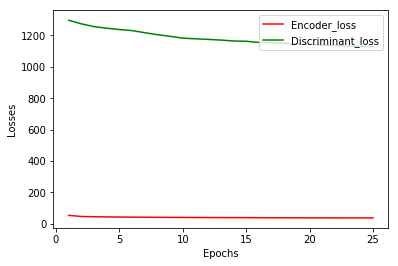

In [11]:
fig2 = plt.figure(1)        
plt.plot(range(1, num_epochs+1),enco_loss,'r-',label='Encoder_loss')        
plt.plot(range(1, num_epochs+1),diss_loss,'g-',label='Discriminant_loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

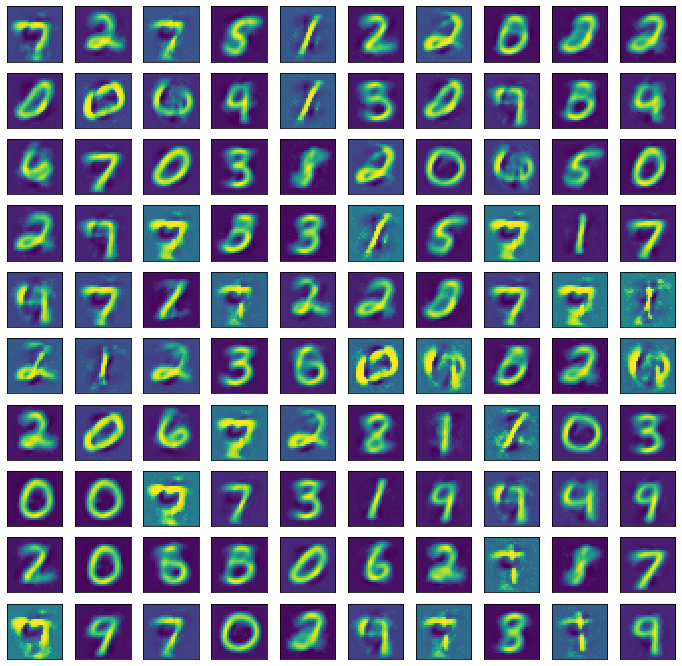

In [22]:
decoder.eval()
z = generate_(100)
generated_images = Variable(decoder(z),requires_grad =False)
z= generated_images.reshape((100,28,28))
z=z.cpu().detach().numpy()
fig=plt.figure(figsize=(12, 12))

columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = z[i-1]
    fig.add_subplot(rows, columns,i)
    
    show = plt.imshow(img)
    show.axes.get_xaxis().set_visible(False)
    show.axes.get_yaxis().set_visible(False)
plt.show()